In [1]:
using Revise
using Pkg; Pkg.activate(".")
using Dates
# using Regex
using Interpolations
using Printf
using PyPlot

# general PSL DAS readers
include("./readers.jl")
using .NoaaDas

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
filename = "./data/PSL/noTRH.txt"
time_re = r"\.\/\d{3}\/me124(\d{3})(\d{2})_raw.txt:(\d{2})(\d{2})(\d{3})"

maxnl = countlines(filename)
T = Matrix{Int32}(undef, (maxnl, 5))

nl = 0
for line in readlines(open(filename))
    M = match(time_re, line)
    if !isnothing(M)
        nl += 1
        T[nl,:] = parse.(Int32, M.captures)
    end
end


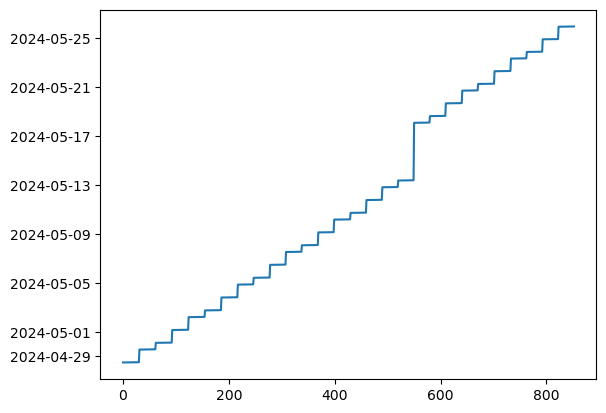

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15afd23e0>

In [3]:
dt = ( DateTime(2024-1,12,31) .+ Day.(T[:,1]) 
        .+ Hour.(T[:,2])  .+ Minute.(T[:,3]) 
        .+ Second.(T[:,4]) .+ Millisecond.(T[:,5]) )

clf()
plot(dt)

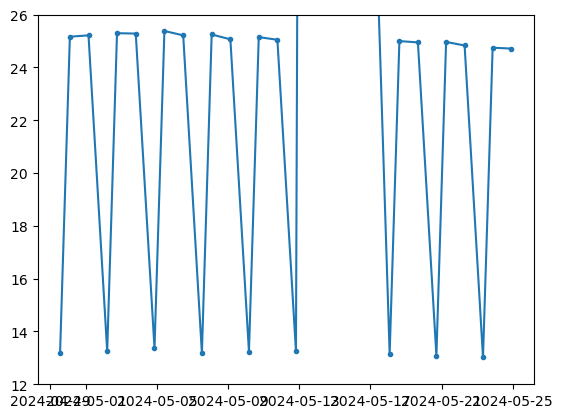

26-element Vector{Int64}:
 30
 30
 30
 30
 30
 30
 29
 30
 29
 29
 30
 29
 30
 29
 29
 29
 29
 29
 29
 30
 29
 30
 30
 29
 29
 29

In [4]:
ist = findall(t->t>Hour(1), diff(dt)) .+ 1
ien = ist .- 1

plot(dt[ist[1:end-1]], Dates.value.(diff(dt[ist]))/3600_000, marker=".")
ylim([11.9999,26])

ien[2:end] .- ist[1:end-1]

T,RH are null / missing between the commas
My reader is skipping and reading the next 2 columns as T,RH!

In [6]:
# fix the reader to return missing when data is null.

# "general PSL DAS readers"
# module NoaaDas

# using Dates
# using Printf

# export get_das_filenames, get_das_pathfiles
# export yday, psldatetime, decimal_hour
# export read_das_dict

# utility functions
# m2n(x) = ismissing(x) ? NaN : x
# pd = permutedims

# general PSL DAS readers

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
# ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::AbstractString) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(secnd) + Millisecond(secnd)
end
function psldatetime(d::Date, hr::Integer=0, minute::Integer=0, secnd::Integer=0, millisecnd::Integer=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(secnd) + Millisecond(millisecnd)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, baseyear=baseyear)
    DateTime(baseyear-1,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=1,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=nsample,
        ncolumn=ncolumn ) # specifying manages memory best
    
    return das_dict(keys, datatime, X) # returns dict
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and parse one das data file"
function read_das_data(pathfilename::AbstractString;
    nheader=1,
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=30 )

    # trivially iterate over 1-vector
    dt, X = read_das_data(pathfilename[1:1];  # changed to read_das_data
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_das_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) .- nheader ),
    ncolumn=30 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                # split in 2 stages, space delimits prepended time
                tsplt = split(line, r"\s+")   # any number of spaces
                @show tsplt[2]
                splt  = split(tsplt[2], r",") # EVERY comma!
                nx = min(ncolumn, length(splt))
                if nx > 0 # skip empty lines
                    nl += 1
                    psltime = tsplt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = parseblank2missing.(Float32, splt)
                    # try
                    #     parseblank2missing.(Float32, splt[2:end])
                    # catch
                    #     error("failed to parse: $(splt[2:end])")
                    # end
                    maxcol = max(maxcol, nx) # data in longest line
                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

"compute the decimal hour of day from a datetime"
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end

# end

Main.NoaaDas

dataline = Float32[12.05871, 28.52733, 5.060144, 0.09682855, 0.1675166, 163.3, 0.0, 0.0, 27.4312, 88.6146, 0.942, 0.0, 0.0]
dataline = Float32[12.0533, 28.55896, 5.059465, 0.109018, 0.2463346, 163.0, 0.0, 0.0, 27.4221, 88.8855, 1.008, 0.0, 0.0]
dataline = Float32[12.05338, 28.5906, 5.058785, 0.09141197, 0.1351122, 163.1, 0.0, 0.0, 27.355, 87.8062, 0.785, 0.0, 0.0]
dataline = Float32[12.059, 28.5906, 5.058785, 0.09039532, 0.1292112, 162.8, 0.0, 0.0, 27.5251, 88.8708, 1.03, 0.0, 0.0]
dataline = Float32[12.04801, 28.62449, 5.060144, 0.09682921, 0.1675206, 163.0, 0.0, 0.0, 27.3893, 87.6935, 0.6950001, 0.0, 0.0]
dataline = Float32[12.04734, 28.65611, 5.058785, 0.1005539, 0.1907425, 163.1, 0.0, 0.0, 27.3601, 87.9804, 0.624, 0.0, 0.0]
dataline = Float32[12.05302, 28.65611, 5.059465, 0.09209068, 0.1390835, 163.2, 0.0, 0.0, 27.434, 89.1819, 0.8580001, 0.0, 0.0]
dataline = Float32[12.05315, 28.69, 5.058785, 0.1015679, 0.1971961, 163.1, 0.0, 0.0, 27.4926, 88.7661, 0.9070001, 0.0, 0.0]
dataline = 

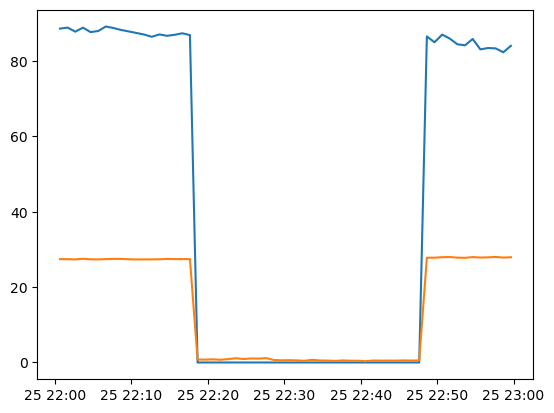

12-element Vector{Union{Missing, Float32}}:
 88.6146f0
 87.9804f0
 87.4555f0
 86.9694f0
  0.0f0
  0.0f0
  0.0f0
  0.0f0
  0.0f0
  0.0f0
 87.0229f0
 83.1015f0

In [9]:
# look at a case
# keys for me1 format
using .NoaaDas

me1keys = [:time, :Batt_Volt, :PTemp, :ORG_Car_v, :ORG_Sig_v, :ORG_mmhr, :airflow, :No_data, :No_data, :Tair, :RH, :Std_Dev_airflow]
D = read_das_dict(get_das_pathfiles("me1", DateTime(2024,5,25,22)),me1keys)
plot(D[:time], D[:RH])
plot(D[:time], D[:Tair])
D[:RH][1:5:end]